##### This analysis is done in python primarily using the pandas library, and jupyter notebook as an interactive interpreter.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
pd.options.display.max_rows = 30

df = pd.read_csv("/Users/Hegstrom/Desktop/HCT390_assignment_ACO data file_downloaded.csv", thousands=',', na_values=['-'])
# Getting everything loaded up, and setting up the dataframe.


# Here, I'm making the savings rate into a percentage. This isn't necessary, I just like the formatting.
df['Sav_rate'] = df['Sav_rate']*100 

# This maps the underlying binary varaible into a human readable format.
hospital_physician_binary = {
    0: 'Physician Group',
    1: 'Hospital Partnership'
}
# Applying the data transformation to the hospital managed column.
df['Hospital_Managed'] = df['Hospital_Managed'].map(hospital_physician_binary)

# All of these are from appendix A in the quality benchmark guideline PDF.
patient_caregiver_columns = ['ACO1','ACO2','ACO3','ACO4','ACO5',
                             'ACO6','ACO7','ACO34']

care_coordination_patient_safety_columns = ['ACO8', 'ACO35', 'ACO36',
                                            'ACO37', 'ACO38', 'ACO43',
                                           'ACO11', 'ACO12', 'ACO13', 'ACO44']

preventative_health_columns = ['ACO14', 'ACO15', 'ACO16', 'ACO17',
                              'ACO18', 'ACO19', 'ACO20', 'ACO42']

at_risk_depression_column = ['ACO40']

at_risk_dm_columns = ['ACO27', 'ACO41', 'DM_Comp']

at_risk_htn_column = ['ACO28']

at_risk_ischemic_vasc_column = ['ACO30']

at_risk_columns = at_risk_depression_column + at_risk_dm_columns + at_risk_htn_column + at_risk_ischemic_vasc_column

# Let's make our data easier to read. Note, I'm doing this is the original dataframe, not the newly spliced one.
# This means I'll need to bring in the new column.
track_classification = {
    0: 'Two Sided Track',
    1: 'One Sided Track'
}

df['Organization Track'] = df['Current_Track_1'].map(track_classification)

# What if there is some way to reduce the number down to reduce the noise, while keeping the info clean? Enter, principal component analysis.

This is not part of the assignment. But, it may be able to give me some insight to whether there are detectable differences.

 ##### Principal component analysis is kind of hard to explain in detail. There's math. Complicated math.

https://en.wikipedia.org/wiki/Principal_component_analysis
    
###### But, what you are looking at is a way to turn 32 columns into 2, reducing the dimensonality, but in a way that preserves the information.

In [10]:
#Lets create a dataframe of the data we want to feed into the PCA.
pca_dataframe = df[['Organization Track'] + ['Hospital_Managed'] + patient_caregiver_columns + care_coordination_patient_safety_columns + preventative_health_columns + at_risk_columns]
pca_dataframe = pca_dataframe.set_index(['Organization Track', 'Hospital_Managed'])

# There are some missing values. This replaces the missing values, by finding it's 5 closest neighbors and using the mean from them.
from sklearn.impute import KNNImputer
imputer = KNNImputer()
pca_input_vals = imputer.fit_transform(pca_dataframe.values)


# Each category should range from 0 to 100,
# but in reality there is some significant variation amongst the quality metrics.
# Let's normalize their values.
from sklearn.preprocessing import Normalizer
scaler = Normalizer()
pca_input_vals = scaler.fit_transform(pca_input_vals)
pca_input_vals

array([[0.22663838, 0.24271693, 0.24053722, ..., 0.14568145, 0.20707229,
        0.22450995],
       [0.22149717, 0.2462299 , 0.24526629, ..., 0.07548302, 0.17492254,
        0.24400824],
       [0.22786778, 0.24665314, 0.24778289, ..., 0.12395713, 0.17340336,
        0.24691587],
       ...,
       [0.22727591, 0.24464122, 0.23995698, ..., 0.1054082 , 0.17668101,
        0.23897355],
       [0.21788296, 0.24627473, 0.24273905, ..., 0.13823711, 0.21846781,
        0.21434728],
       [0.21580204, 0.24400798, 0.24054876, ..., 0.10084953, 0.18347165,
        0.23283204]])

Text(0.5, 1.0, 'PCA - Hospital Managment')

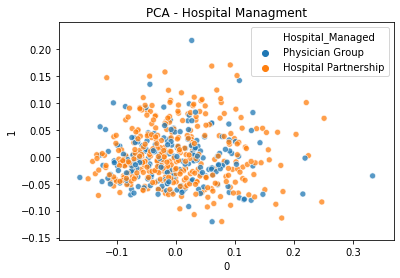

In [11]:
# Now, let's run a PCA analysis.
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pca_obj = PCA(n_components=2)
output = pca_obj.fit_transform(pca_input_vals)
output_df = pd.DataFrame(output)

output_df.index = pca_dataframe.index.get_level_values(1)
output_df = output_df.reset_index()

ax = sns.scatterplot(data=output_df, x=0, y=1, hue='Hospital_Managed', alpha=.75)
plt.title('PCA - Hospital Managment')

The above chart shows the first two principal components. They unfortunately don't seem to discriminant the hospital management type, based on the quality scores.

Here's an example that DOES show some seperation:



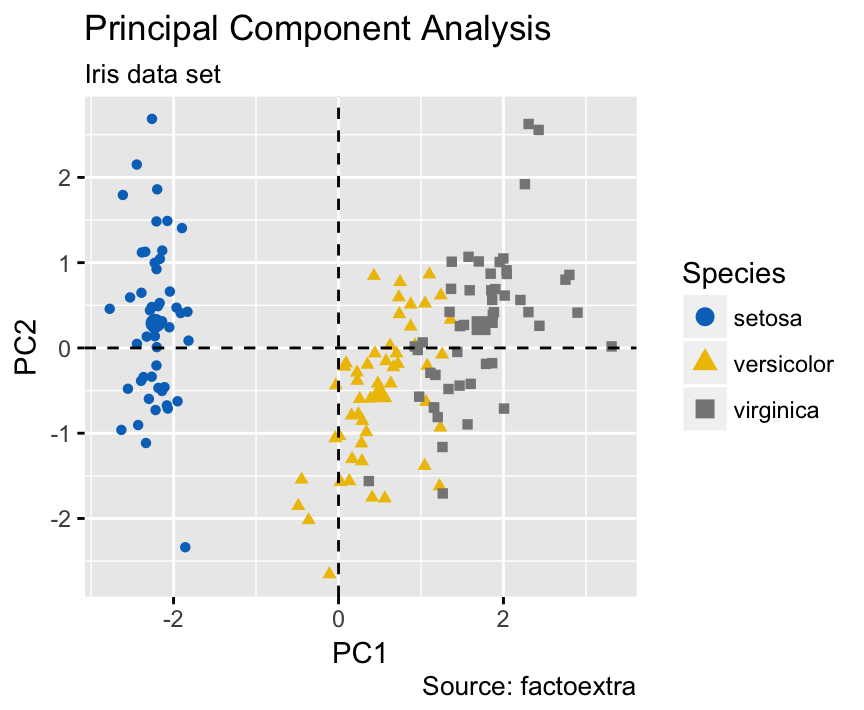

In [12]:
from IPython.display import Image
Image("http://www.sthda.com/english/sthda-upload/figures/principal-component-methods/006-principal-component-analysis-graphical-parameters-1.png",
     width=487, height=400)

Let's take a look at the organization's track:

Text(0.5, 1.0, 'PCA - Organization Track')

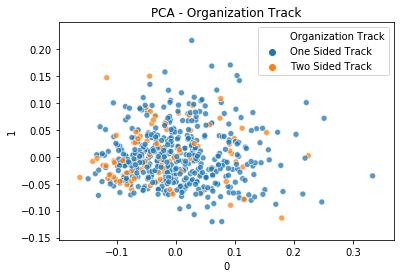

In [13]:
del output_df['Hospital_Managed']
output_df.index = pca_dataframe.index.get_level_values(0)
output_df = output_df.reset_index()
output_df
sns.scatterplot(data=output_df, x=0, y=1, hue='Organization Track', alpha=.75)
plt.title('PCA - Organization Track')

Again, there's no real distinct clusters. They're all mixed together, indicating there likely isn't any significant distinction between the two organization tracks based on their quality metrics.